In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import itertools
import time

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn import metrics

from sqlalchemy import create_engine
import datetime 
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib
pd.options.display.max_columns=300
pd.options.display.max_rows=100
# from TurbineTimeSeries.storage import MachineDataStore
plt.rcParams["figure.figsize"] = (14,8)
#from TurbineTimeSeries.transformations import PCA, StandardScaler, DropCols, DropSparseCols, LeftJoin
%matplotlib inline

In [2]:
# model_number = 2

# store = MachineDataStore('.config')

# # model_data_hr = (store.query(model_number,'1hr')
# #                  .not_null(['timestamp','psn'])
# # #                  .exclude_psn([44,52,54,70])
# #                  .execute())

# model_data_min = (store.query(model_number,'10min')
#                   .not_null(['timestamp','psn'])
#                   .exclude_psn([44,52,54,70])
#                   .execute())

# model_data_min.head()
# model1_1hr = pd.read_csv('../../../data/raw_data_model1.csv',index_col=0)
# model2_1hr = pd.read_csv('../../../data/raw_data_model2.csv',index_col=0)

# model1_10min = pd.read_csv('../../../data/raw_data_model1_10min.csv',index_col=0)
model2_10min = pd.read_csv('../../../data/raw_data_model2_10min.csv')#,index_col=0)

## convert all to timestamps
# model1_1hr['timestamp'] = model1_1hr['timestamp'].apply(lambda x: pd.Timestamp(x))
# model2_1hr['timestamp'] = model2_1hr['timestamp'].apply(lambda x: pd.Timestamp(x))
# model1_10min['timestamp'] = model1_10min['timestamp'].apply(lambda x: pd.Timestamp(x))
model2_10min['timestamp'] = model2_10min['timestamp'].apply(lambda x: pd.Timestamp(x))


# print('Shape of model1 1hr data: ', model1_1hr.shape)
# print('Shape of model2 1hr data: ', model2_1hr.shape)
# print('Shape of model1 10min data: ', model1_10min.shape)
print('Shape of model2 10min data: ', model2_10min.shape)

Shape of model2 10min data:  (1602326, 76)


In [3]:
data_dictionary = pd.read_csv('data_dictionary_model2.csv')
# data_dictionary

In [4]:
# [type(model2_10min.head()['timestamp'][0]) ## should be timestamp]
[i for i in data_dictionary['COLUMN_NAME'].str.lower().values if i not in model2_10min.columns.unique()]

['lo_c_brg1']

In [5]:
subsystem_dict = {str(i).lower(): list(data_dictionary[data_dictionary['SUBSYSTEM']==i]['COLUMN_NAME'].str.lower().values) for i in data_dictionary['SUBSYSTEM'].unique()}
del subsystem_dict['summary'] ## this group pretty useless

In [6]:
print(list(subsystem_dict.keys()))

['gas path', 'fuel', 'generator', 'vibration', 'lube oil system', 'enclosure', 'package equipment']


In [7]:
for i in subsystem_dict.keys():
    print(i,len(subsystem_dict[i]))

gas path 29
fuel 12
generator 12
vibration 6
lube oil system 8
enclosure 2
package equipment 1


In [8]:
def subsystem_pca(df,subsystem_dict,subsystems = [], psns = 'all'):
    
    subset = []
    if isinstance(subsystems,list)==True:
        if len(subsystems) > 0:
            for i in subsystems:
                subset = subset + subsystem_dict[i] ## populate subset with list of columns
        else:
            print('Empty list of subsystems detected. Using all subsystems for PCA')
            subset = [s for L in subsystem_dict.keys() for s in subsystem_dict[L]]
    else: 
        raise Exception('Please ensure subsystems parameter is a list')
        
    if psns == 'all' or isinstance(psns, (list, int))==True:
        pass
    else:
        raise Exception('Please provide a list of psns, single psn, or "all"')
    


    available_subset = [i for i in subset if i in df.columns.values]
    if len(available_subset)<len(subset):
        print('excluding columns: ', list(set(subset)-set(available_subset)))
    available_subset =  available_subset + ['id','timestamp','psn']
    model_data = df[available_subset]
    
    
    
    skipped_cols = ['sum_esn','sum_eng_st', 'sum_eng_h']
    index_cols = ['id','timestamp','psn']
    data_cols = [c for c in model_data.columns if (c not in index_cols) and (c not in skipped_cols)]
    
    missing_values = model_data.isnull().sum().sort_values()
    sparse_cols = [x for x in missing_values.index if missing_values[x] > 30000]
    clean_data_cols = [x for x in data_cols if x not in sparse_cols]
    data = model_data[index_cols + clean_data_cols].dropna()#.reset_index()
    clean_data = StandardScaler().fit_transform(data[clean_data_cols])

    pca =  PCA().fit(clean_data)
    reduced = pca.transform(clean_data)
    reduced_df = pd.DataFrame(reduced)
    reduced_df['psn'] = data.psn.values
    reduced_df['timestamp'] = data.timestamp.values
    return(reduced_df)

In [9]:
def plot_eigs_subplots(reduced_df, n_eigs_x, n_eigs_y, psns, savefig = False,path=None,figname = None):
    if isinstance(n_eigs_x,int) == True:
        pass
    else:
        raise Exception('n_eigs_x must be an integer')
        
    if isinstance(n_eigs_y,int) == True:
        pass
    else:
        raise Exception('n_eigs_y must be an integer')
    

    
    if psns == 'all':
#         fig_base_title = 'All psns'
        pass
    elif isinstance(psns, list)==True:
        model2_10min[model2_10min['psn'].isin(psns)]
#         fig_base_title = 'PSN ' + str(psns)
        
    elif isinstance(psns,int) == True:
        reduced_df = reduced_df[reduced_df['psn']==psns]
#         fig_base_title = 'PSN ' + str(psns)
    else:
        raise Exception('Please provide a list of psns, single psn, or "all"')
        
    if path == None:
        path = ''
    else:
        pass

        
    f, axarr = plt.subplots(n_eigs_x, n_eigs_y)
    f.set_figheight(40)
    f.set_figwidth(40)
    f.suptitle(path + fname,fontsize=16)
    for i in range(n_eigs_x):
        for j in range(n_eigs_y):

            if i==j:
                continue
            axarr[i, j].scatter(reduced_df[i].values,reduced_df[j].values,3,alpha=0.5)
            axarr[i, j].set_title('Eig '+str(i) + ' vs Eig '+ str(j))
    if savefig == False:
        plt.show()
    else:
        
        f.savefig(path+str('\\') + fname +'.png')      
#         f.suptitle(path + fig_base_title + ' ' + str(n_eigs_x) + 'x' + str(n_eigs_y) + ' subplots',fontsize=16)
#         f.savefig(path + fig_base_title + ' ' + str(n_eigs_x) + 'x' + str(n_eigs_y) + ' subplots.png')
#         plt.show()
        plt.close()

In [10]:
# rd_df = subsystem_pca(model2_10min,subsystem_dict, ['gas path'], psns = 'all')

In [11]:
# fname = 'All Psns ["enclosure"] ' + str(5) + 'x' + str(5) + ' subplots'
# plot_eigs_subplots(reduced_df=rd_df,n_eigs_x=5,n_eigs_y=5,psns='all',savefig=False,path='Eig Explorer',figname = 'test')

## looping through potential subsystems/tags to look for clusters in eigs

In [10]:
print(len(subsystem_dict.keys()))
print(subsystem_dict.keys())

7
dict_keys(['gas path', 'fuel', 'generator', 'vibration', 'lube oil system', 'enclosure', 'package equipment'])


In [11]:
combos = [list(subset) for L in range(5,len(subsystem_dict.keys())+1) for subset in itertools.combinations( subsystem_dict.keys(),L) ]
print(len(combos))

29


In [49]:
rd_df = subsystem_pca(model2_10min,subsystem_dict, ['gas path', 'fuel', 'lube oil system','generator'], psns = 'all')
rd_df['id'] = model2_10min['id']

excluding columns:  ['lo_c_brg1']


In [50]:
reduced_onepsn = rd_df[rd_df['psn']==46]
# raw_data_psn46 = model2_10min[model2_10min['psn']==46]
# joined_psn46 = model2  data[index_cols].merge(top20_reduced, left_on='id', right_on='id')

In [51]:
## perhaps subset to top 20 eigenvectors???
no_clusts = 3
num_eigs_toclust = 20
kmeans = KMeans(init='k-means++', n_clusters=no_clusts, n_init=10)
## clusters all rows, only columns 0 to from num_eigs_toclust (excludes the id,psn,timestamp cols)
kmeans_results = kmeans.fit_predict(reduced_onepsn[list(range(num_eigs_toclust))]) ## returns a 1-d array of which cluster each row is in


In [52]:
from collections import Counter
Counter(kmeans_results)

Counter({0: 2486, 1: 2159, 2: 2947})

In [53]:
print(reduced_onepsn.shape)
print(len(kmeans_results))

(7592, 63)
7592


In [54]:
reduced_onepsn['cluster'] = kmeans_results

C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [55]:
reduced_onepsn.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,psn,timestamp,id,cluster
1264634,9.211979,-2.158806,-0.343555,-0.377279,-0.823370,1.087405,2.692892,-1.703153,-1.909098,-0.369333,1.182790,1.465310,-1.468975,-0.628691,-0.179029,-0.387516,0.219731,1.348865,0.321525,-1.309365,0.077360,-1.161937,-1.721432,0.253070,-0.410673,0.299955,-0.253644,-0.477212,-0.296865,0.008909,0.171596,-0.394220,-0.413811,0.515916,0.555439,-0.063397,0.289295,0.005663,0.047686,0.016432,-0.035485,-0.064156,0.018483,0.017029,0.002847,-0.000077,-3.421672e-08,-4.533468e-06,-1.289237e-07,-2.156138e-07,5.478496e-08,-1.932882e-07,-1.326017e-07,-1.167277e-07,-3.645373e-08,2.101184e-08,5.538013e-08,5.272280e-08,-6.989018e-08,7.247185e-08,46,2017-09-01 02:40:00.000001,355796,0
1264635,9.456161,-2.267411,-0.581014,-0.418438,-0.675334,0.883652,2.223807,-1.863077,-2.037009,-0.321759,0.727956,0.730082,-1.911186,-0.775545,0.136059,-0.489211,0.280030,1.816699,0.241238,-1.270464,-0.123740,-1.063395,-1.258965,0.614902,-0.587499,0.258872,-0.012071,-0.778657,-0.132801,0.136529,-0.204307,-0.918560,-0.925241,0.348963,0.539106,0.032059,0.358928,0.009560,0.031185,0.027125,-0.053601,-0.030143,0.011448,0.012113,0.005029,-0.000030,-2.047429e-08,-2.118372e-06,-1.230613e-07,-3.694352e-07,-2.086373e-08,4.058181e-08,-7.812663e-09,5.898871e-08,1.964632e-07,-1.137970e-07,-4.596766e-08,-1.047898e-07,-4.667847e-08,3.599125e-08,46,2017-09-01 02:49:59.999995,355797,0
1264636,9.270052,-2.225316,-0.539943,-0.378919,-0.745743,0.744395,2.243108,-1.858298,-1.956667,-0.470253,0.714601,0.707421,-1.952180,-0.874488,-0.044564,-0.251779,0.144553,1.434696,-0.140396,-1.790507,0.083666,-1.186242,-1.750155,0.489771,-0.375203,0.160688,0.210337,-0.477530,-0.035006,0.031215,-0.063531,-0.618267,-0.818045,0.383519,0.601355,-0.009539,0.369288,-0.009493,0.026538,0.029140,-0.071137,-0.048375,0.010531,0.013656,0.005941,-0.000121,-6.175562e-08,-1.721346e-06,1.868411e-07,2.006555e-07,4.008011e-08,1.514959e-07,-2.917108e-07,-1.417851e-07,-2.020492e-08,1.013630e-07,1.403945e-07,2.091840e-07,-2.438243e-08,9.500838e-08,46,2017-09-01 03:00:00.000000,355798,0
1264637,9.421652,-2.144164,-0.460634,-0.352433,-0.550907,1.103431,2.752193,-1.637656,-1.823879,-0.028680,1.226307,2.081826,-1.519577,-0.750576,-0.095697,-0.400331,0.227411,1.613188,0.088637,-1.466303,-0.005657,-0.911784,-1.413169,0.553297,-0.609030,0.324780,-0.237849,-0.869222,-0.252609,0.093793,-0.143629,-0.843942,-0.791341,0.410620,0.627568,0.022514,0.384933,0.013165,0.028152,0.030152,-0.048058,-0.019192,0.012709,0.011727,0.002233,0.000013,1.755512e-07,2.703899e-07,-2.375814e-07,-1.548054e-07,3.565256e-08,3.119810e-08,-3.509601e-08,-5.693661e-08,-1.255366e-07,1.729475e-09,-1.712076e-07,-1.081859e-07,9.863507e-09,5.574216e-08,46,2017-09-01 03:10:00.000004,355799,0
1264638,9.532428,-2.239078,-0.657760,-0.523091,-0.915711,0.777335,2.015521,-1.947613,-2.230829,-0.701298,0.515334,-0.430962,-2.393397,-0.455329,0.609120,-0.606457,0.360594,1.948825,0.719949,-0.815876,-0.212470,-0.925275,-1.417380,0.546083,-0.353188,0.285925,0.015571,-0.752743,-0.192269,-0.068765,-0.250537,-0.634272,-0.869172,0.311961,0.506557,-0.032193,0.304288,0.014205,0.047809,0.004409,-0.045950,-0.047604,0.010142,0.013425,0.003460,0.000022,5.684739e-08,-3.301689e-06,4.857361e-08,6.466599e-08,9.459664e-08,9.596182e-08,-5.505608e-08,-1.485324e-07,-7.838448e-08,1.208560e-08,1.252223e-07,5.131572e-08,-7.900640e-08,7.667233e-08,46,2017-09-01 03:19:59.999998,355800,0


In [11]:
color_pal = ['#33a02c', '#1f78b4', '#ff7f00', '#a6cee3','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#cab2d6','#6a3d9a']

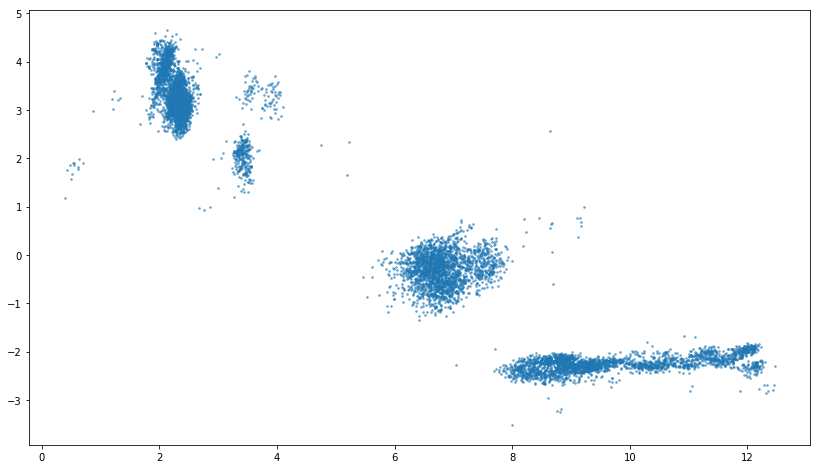

In [57]:
plt.figure(figsize=(14,8))
plt.scatter(reduced_onepsn[0].values,reduced_onepsn[1].values,s=3,alpha=0.5)
plt.show()

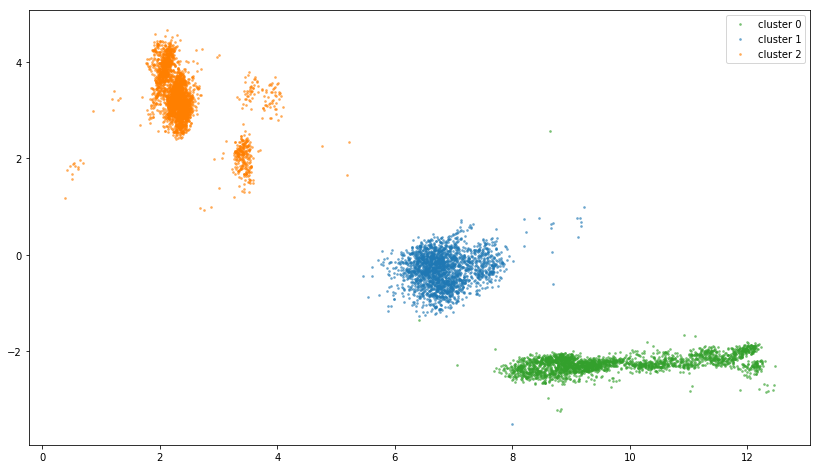

In [58]:
plt.figure(figsize=(14,8))
for i in sorted(reduced_onepsn['cluster'].unique()):
    tempdf = reduced_onepsn[reduced_onepsn['cluster']==i]
    plt.scatter(tempdf[0].values,tempdf[1].values,s=3,alpha=0.5,c=color_pal[i],label = 'cluster '+str(i))
plt.legend()
plt.show()

In [61]:
tempdf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,psn,timestamp,id,cluster,colormap
1264634,9.211979,-2.158806,-0.343555,-0.377279,-0.823370,1.087405,2.692892,-1.703153,-1.909098,-0.369333,1.182790,1.465310,-1.468975,-0.628691,-0.179029,-0.387516,0.219731,1.348865,0.321525,-1.309365,0.077360,-1.161937,-1.721432,0.253070,-0.410673,0.299955,-0.253644,-0.477212,-0.296865,0.008909,0.171596,-0.394220,-0.413811,0.515916,0.555439,-0.063397,0.289295,0.005663,0.047686,0.016432,-0.035485,-0.064156,0.018483,0.017029,0.002847,-0.000077,-3.421672e-08,-4.533468e-06,-1.289237e-07,-2.156138e-07,5.478496e-08,-1.932882e-07,-1.326017e-07,-1.167277e-07,-3.645373e-08,2.101184e-08,5.538013e-08,5.272280e-08,-6.989018e-08,7.247185e-08,46,2017-09-01 02:40:00.000001,355796,0,#33a02c
1264635,9.456161,-2.267411,-0.581014,-0.418438,-0.675334,0.883652,2.223807,-1.863077,-2.037009,-0.321759,0.727956,0.730082,-1.911186,-0.775545,0.136059,-0.489211,0.280030,1.816699,0.241238,-1.270464,-0.123740,-1.063395,-1.258965,0.614902,-0.587499,0.258872,-0.012071,-0.778657,-0.132801,0.136529,-0.204307,-0.918560,-0.925241,0.348963,0.539106,0.032059,0.358928,0.009560,0.031185,0.027125,-0.053601,-0.030143,0.011448,0.012113,0.005029,-0.000030,-2.047429e-08,-2.118372e-06,-1.230613e-07,-3.694352e-07,-2.086373e-08,4.058181e-08,-7.812663e-09,5.898871e-08,1.964632e-07,-1.137970e-07,-4.596766e-08,-1.047898e-07,-4.667847e-08,3.599125e-08,46,2017-09-01 02:49:59.999995,355797,0,#33a02c
1264636,9.270052,-2.225316,-0.539943,-0.378919,-0.745743,0.744395,2.243108,-1.858298,-1.956667,-0.470253,0.714601,0.707421,-1.952180,-0.874488,-0.044564,-0.251779,0.144553,1.434696,-0.140396,-1.790507,0.083666,-1.186242,-1.750155,0.489771,-0.375203,0.160688,0.210337,-0.477530,-0.035006,0.031215,-0.063531,-0.618267,-0.818045,0.383519,0.601355,-0.009539,0.369288,-0.009493,0.026538,0.029140,-0.071137,-0.048375,0.010531,0.013656,0.005941,-0.000121,-6.175562e-08,-1.721346e-06,1.868411e-07,2.006555e-07,4.008011e-08,1.514959e-07,-2.917108e-07,-1.417851e-07,-2.020492e-08,1.013630e-07,1.403945e-07,2.091840e-07,-2.438243e-08,9.500838e-08,46,2017-09-01 03:00:00.000000,355798,0,#33a02c
1264637,9.421652,-2.144164,-0.460634,-0.352433,-0.550907,1.103431,2.752193,-1.637656,-1.823879,-0.028680,1.226307,2.081826,-1.519577,-0.750576,-0.095697,-0.400331,0.227411,1.613188,0.088637,-1.466303,-0.005657,-0.911784,-1.413169,0.553297,-0.609030,0.324780,-0.237849,-0.869222,-0.252609,0.093793,-0.143629,-0.843942,-0.791341,0.410620,0.627568,0.022514,0.384933,0.013165,0.028152,0.030152,-0.048058,-0.019192,0.012709,0.011727,0.002233,0.000013,1.755512e-07,2.703899e-07,-2.375814e-07,-1.548054e-07,3.565256e-08,3.119810e-08,-3.509601e-08,-5.693661e-08,-1.255366e-07,1.729475e-09,-1.712076e-07,-1.081859e-07,9.863507e-09,5.574216e-08,46,2017-09-01 03:10:00.000004,355799,0,#33a02c
1264638,9.532428,-2.239078,-0.657760,-0.523091,-0.915711,0.777335,2.015521,-1.947613,-2.230829,-0.701298,0.515334,-0.430962,-2.393397,-0.455329,0.609120,-0.606457,0.360594,1.948825,0.719949,-0.815876,-0.212470,-0.925275,-1.417380,0.546083,-0.353188,0.285925,0.015571,-0.752743,-0.192269,-0.068765,-0.250537,-0.634272,-0.869172,0.311961,0.506557,-0.032193,0.304288,0.014205,0.047809,0.004409,-0.045950,-0.047604,0.010142,0.013425,0.003460,0.000022,5.684739e-08,-3.301689e-06,4.857361e-08,6.466599e-08,9.459664e-08,9.596182e-08,-5.505608e-08,-1.485324e-07,-7.838448e-08,1.208560e-08,1.252223e-07,5.131572e-08,-7.900640e-08,7.667233e-08,46,2017-09-01 03:19:59.999998,355800,0,#33a02c


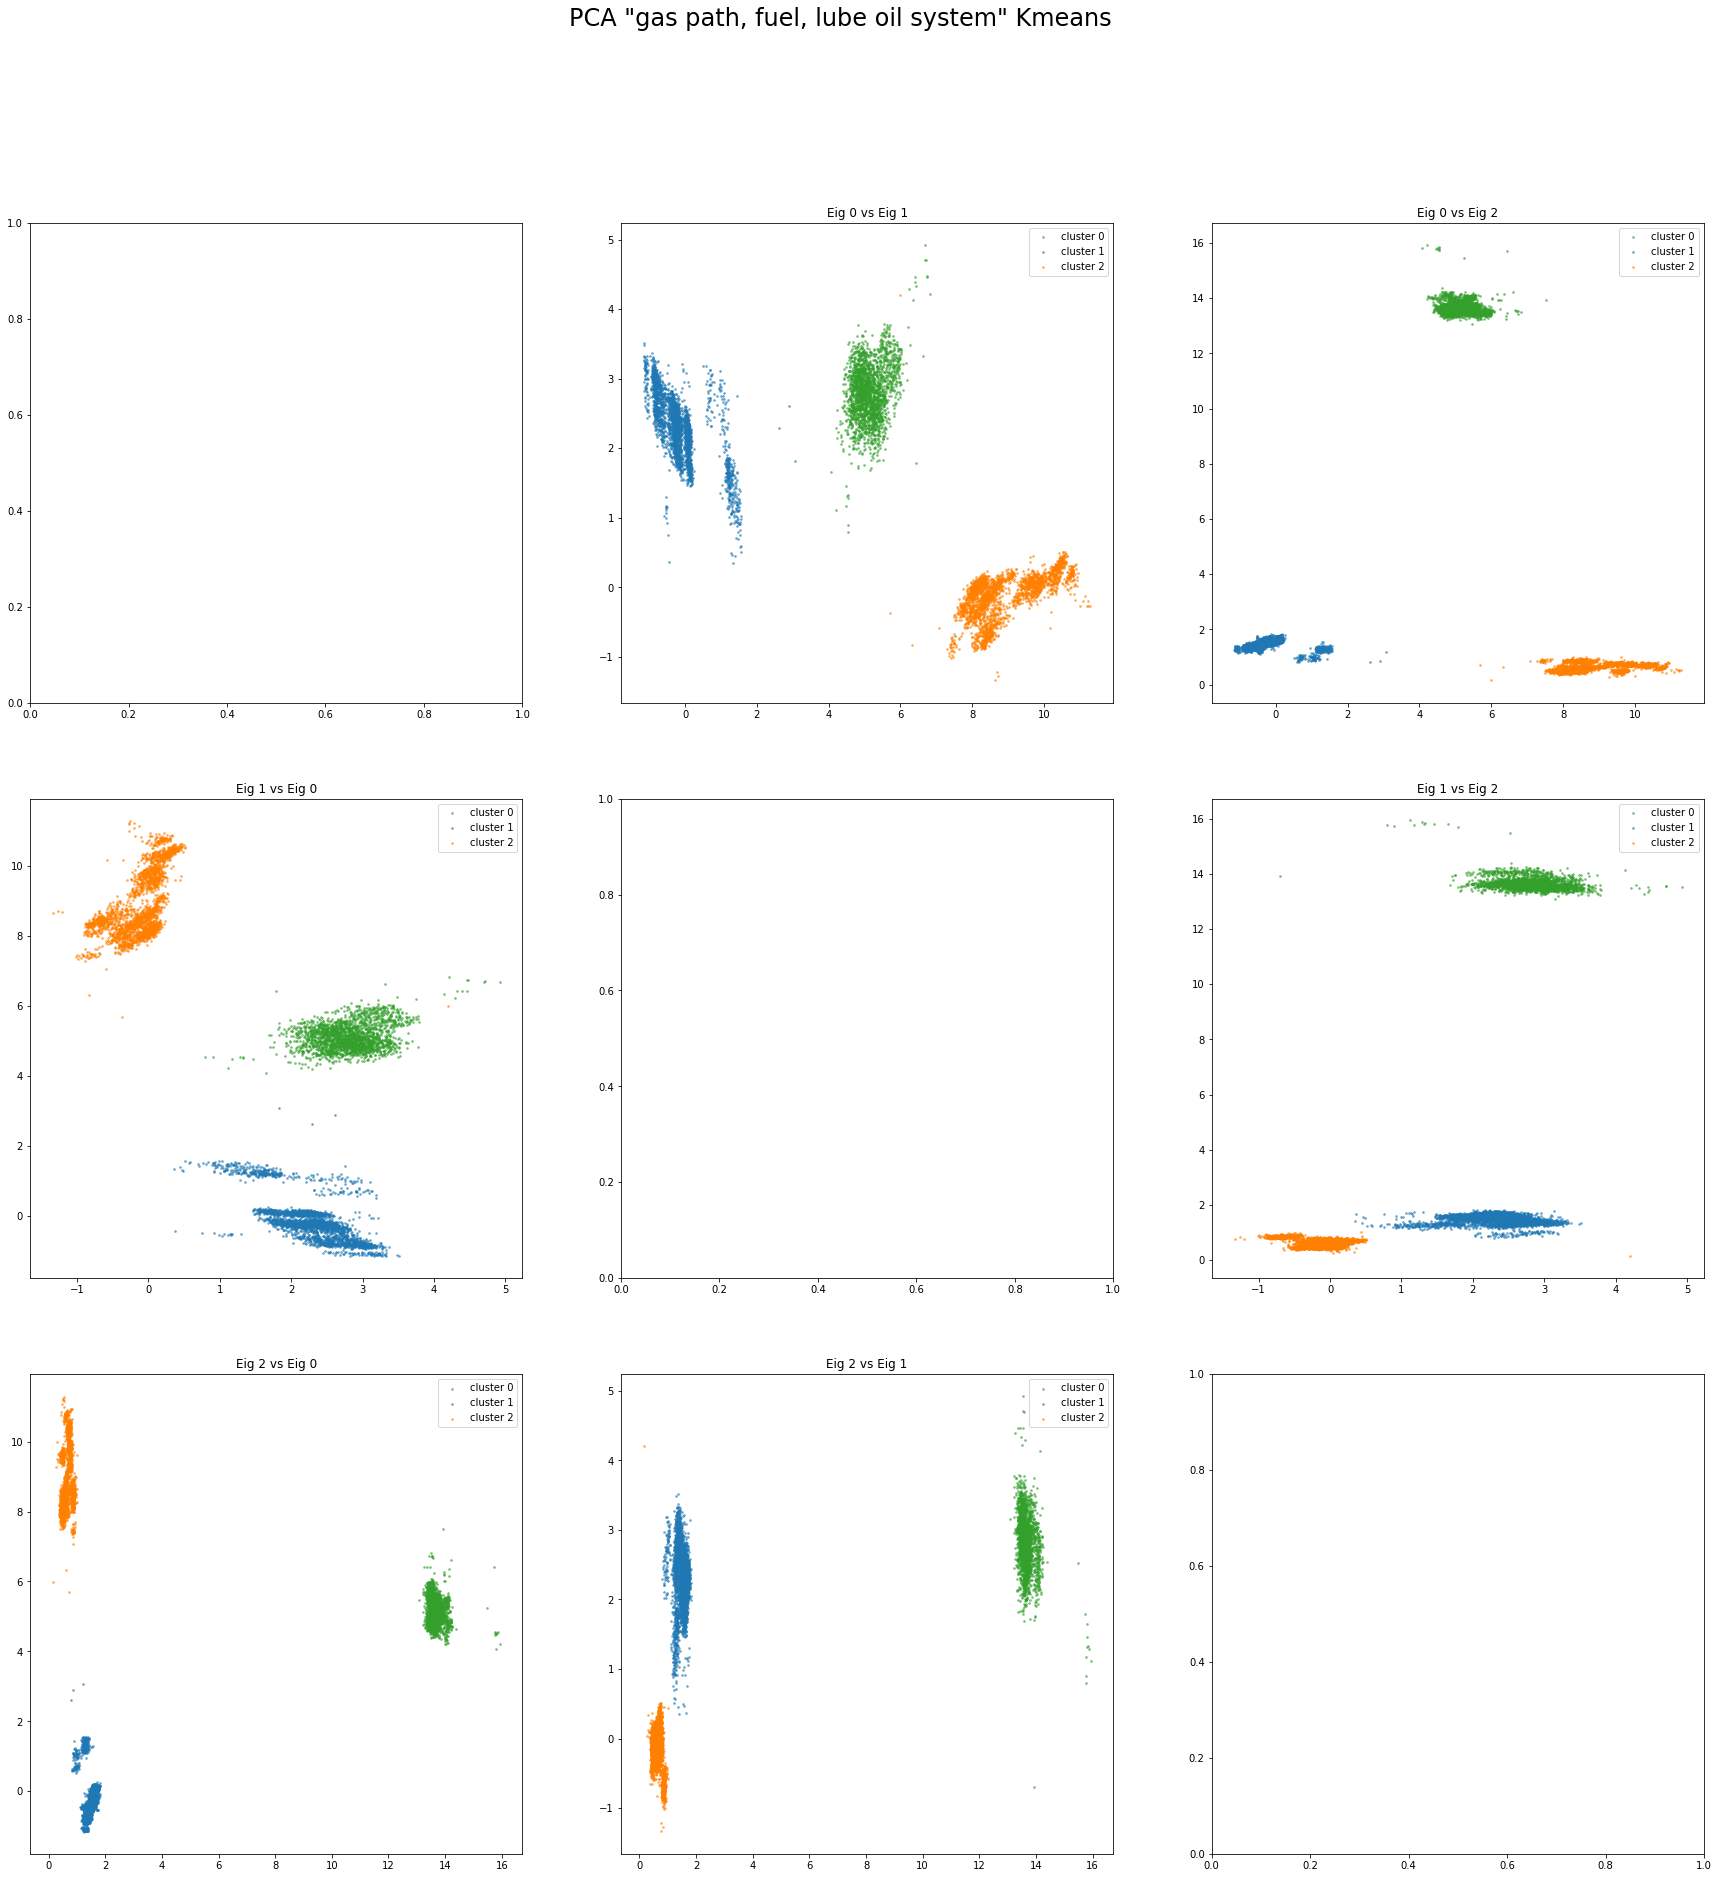

In [48]:
n_eigs_x=3
n_eigs_y=3
f, axarr = plt.subplots(n_eigs_x, n_eigs_y)
f.set_figheight(30)
f.set_figwidth(30)
f.suptitle('PCA "gas path, fuel, lube oil system" Kmeans',fontsize=24)
for i in range(n_eigs_x):
    for j in range(n_eigs_y):
        if i==j:
            continue
        for k in sorted(reduced_onepsn['cluster'].unique()):
            tempdf = reduced_onepsn[reduced_onepsn['cluster']==k]
            
            axarr[i, j].scatter(tempdf[i].values,tempdf[j].values,s=3,alpha=0.5,c=color_pal[k],label = 'cluster '+str(k))
            axarr[i, j].set_title('Eig '+str(i) + ' vs Eig '+ str(j))
            axarr[i, j].legend()
plt.show()

In [31]:
from sklearn.cluster import AffinityPropagation, MeanShift, spectral_clustering, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
## for agglomerative clustering, give linkage : {“ward”, “complete”, “average”}

n_clusts = 2
kmeans = KMeans(init='k-means++', n_clusters=no_clusts, n_init=10)
AffinityProp = AffinityPropagation()
Meanshift = MeanShift()
Spectral = spectral_clustering()
Agglom_ward = AgglomerativeClustering(n_clusters=n_clusts, linkage='ward')
Agglom_complete = AgglomerativeClustering(n_clusters=n_clusts, linkage='complete')
Agglom_avg = AgglomerativeClustering(n_clusters=n_clusts, linkage='average')
Dbscan = DBSCAN(eps=5, min_samples=n_clusts)
GMM_spherical = GaussianMixture(n_components=n_clusts covariance_type='spherical' )
GMM_diag = GaussianMixture(n_components=n_clusts covariance_type='diag' )
GMM_tied = GaussianMixture(n_components=n_clusts covariance_type='tied' )
GMM_full = GaussianMixture(n_components=n_clusts covariance_type='full' )



clustering_algo_dict = {'kmeans':kmeans, 'AffinityProp': AffinityProp,'Meanshift':Meanshift, 'Spectral':Spectral,
                        'Agglom_ward':Agglom_ward,'Agglom_complete':Agglom_complete,'Agglom_avg':Agglom_avg,
                       'Dbscan':Dbscan,'GMM_spherical':GMM_spherical,'GMM_diag':GMM_diag, 'GMM_tied':GMM_tied,
                        'GMM_full':GMM_full}

In [196]:
# rd_df = subsystem_pca(model2_10min,subsystem_dict, subsystems=[], psns = 'all')
# rd_df['id'] = model2_10min['id']

######
# try these packages:
# 35,49,56,59,61,65. 49 most promising?
######

no_clusts = 2
num_eigs_toclust = 20
reduced_onepsn = rd_df[rd_df['psn']==49]
clustering_algo = 'DBSCAN'

# kmeans = KMeans(init='k-means++', n_clusters=no_clusts, n_init=10)
index_cols = ['id','timestamp','psn']
other_cols = [j for j in reduced_onepsn.columns.values if j not in index_cols]
reduced_onepsn_scaled = StandardScaler().fit_transform(reduced_onepsn[other_cols])
for i in index_cols:
    reduced_onepsn_scaled[i] = reduced_onepsn[i]


kmeans  = DBSCAN(eps=0.5)
kmeans_results = kmeans.fit_predict(reduced_onepsn_scaled[list(range(num_eigs_toclust))]) ## returns a 1-d array of which cluster each row is in
reduced_onepsn['cluster'] = kmeans_results

f, axarr = plt.subplots(2,1)
f.set_figheight(30)
f.set_figwidth(30)
f.suptitle('PCA all subsystems ' + str(clustering_algo))
for i in sorted(reduced_onepsn_scaled['cluster'].unique()):
    tempdf = reduced_onepsn_scaled[reduced_onepsn_scaled['cluster']==i]
    axarr[0].scatter(tempdf[0].values,tempdf[1].values,s=3,alpha=0.5,c=color_pal[i],label = 'cluster '+str(i))
    axarr[1].plot(tempdf['timestamp'].values,tempdf[0].values,alpha=0.5,c=color_pal[i],label = 'cluster '+str(i))
    
axarr[0].legend()
plt.show()

### use below for subplots

# n_eigs_x=3
# n_eigs_y=3
# f, axarr = plt.subplots(n_eigs_x, n_eigs_y)
# f.set_figheight(30)
# f.set_figwidth(30)
# f.suptitle('PCA all subsystems Kmeans',fontsize=24)
# for i in range(n_eigs_x):
#     for j in range(n_eigs_y):
#         if i==j:
#             continue
#         for k in sorted(reduced_onepsn['cluster'].unique()):
#             tempdf = reduced_onepsn[reduced_onepsn['cluster']==k]
            
#             axarr[i, j].scatter(tempdf[i].values,tempdf[j].values,s=3,alpha=0.5,c=color_pal[k],label = 'cluster '+str(k))
#             axarr[i, j].set_title('Eig '+str(i) + ' vs Eig '+ str(j))
#             axarr[i, j].legend()
# plt.show()

KeyboardInterrupt: 

### notable combinations

gas path, fuel, enclosure, (+ any others) 
gas path, fuel, generator (+any others)
gas path, fuel, enclosure, lube oil eig 0vs2
gas path, fuel, lube oil eig 0vs2
** honestly really anything with just gas path and fuel

gas path, generator, package equip eig 0vs3
gas path, generator, vibration, enclosure, package equip eig 0vs3
gas path, generator, vibration, enclosure eig 0vs3
gas path, generator, vibration, package equip eig 0vs3
gas path, generator, vibration eig 0vs3
kinda 3 clusters with only gas path and generator but clearer with a third

generator, enclosure eig 1 vs 3
generator, package equip eig 0 vs 3, eig 1 vs 3, eig 2 vs 3, eig 3 vs 4
generator, eig 1 vs 3, eig 2 vs 3, eig 3 vs 4

fuel, generator, enclosure, package equip eig 1 vs 3
fuel, generator, enclosure, lube oil (slightly clearer +package equip) eig 0 vs 1, eig 1 vs 2, eig 1 vs 3
fuel, generator, lube oil, enclosure eig 0 vs 1
fuel, generator, lube oil, enclosure, package equip eig 0 vs 1
fuel, generator, lube oil eig 0 vs 1

fuel, vibration, lube oil eig 0 vs 1

